# aSPEM Experiment : analysis


Test de différtentes pentes $k$ pour la relation entre $p_bet$ et $\hat{p}$


In [1]:
%run ../0_parameters.ipynb


WELCOME



In [2]:
import glob
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [4]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


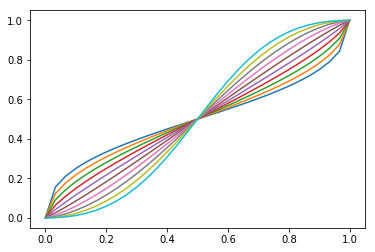

In [5]:
p = np.linspace(0, 1, 31)
def sigmoid(y):
    return 1 / (1 + np.exp(-y))
def logit(p):
    return np.log(p / (1 - p))
    
#plt.plot(p, sigmoid(4.*logit(p)))
for k in np.logspace(-1, 1, 10, base=2):
    plt.plot(p, sigmoid(k*logit(p)))

In [6]:
def r_(p, data) :
    
    p = np.ma.masked_array(p, mask=np.isnan(data)).compressed()
    data = np.ma.masked_array(data, mask=np.isnan(data)).compressed()

    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    
    return r_

In [9]:
Full = e.Full_list(modes_bcp=[])
modes_bcp = 'mean'
tau = np.arange(1, 603, 1)
list_h = 1/tau

r_k_s, h_k_s = {}, {}
for num, s in enumerate(list(set(Full.sujet))):
    print(s, end=' ')
    
    bet = Full['results'][Full.sujet==s].values.tolist()
    x = np.array(Full['bino'][Full.sujet==s].values.tolist())

    r_k, h_k = [], []
    for k in range(11) : r_k.append([]) ; h_k.append([])
    
    for num, k in enumerate(np.logspace(-1, 1, 10, base=2)) :
        
        r_bet_l, r_bet_ = [], []
        for c in range(0, 3*200-150, 200) : r_bet_l.append([]) ; r_bet_.append([])
        
        for h in list_h :

            for d, c in enumerate(range(0, 3*200-150, 200)) :
                x_100, p_hat_100 = x[c:c+200], np.zeros(200)

                liste = [0, 50, 100, 150, 200]
                for a in range(len(liste)-1) :
                    p_bar, r_bar, beliefs = bcp.inference(x_100[liste[a]:liste[a+1]], h=h, p0=.5, r0=1.)
                    p_hat_p, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=modes_bcp, p0=.5, fixed_window_size=40)
                    p_hat_100[liste[a]:liste[a+1]] = p_hat_p

                if num==0 : r_bet_[d].append(r_(p_hat_100.tolist(), bet[c:c+200]))
                r_bet_l[d].append(r_(sigmoid(k*logit(p_hat_100)), bet[c:c+200]))

        h_bet_logit, h_bet = [], []
        r_bet_logit, r_bet = [], []
        for d, c in enumerate(range(0, 3*200-150, 200)) :

            if num==0 :
                h_bet.append(list_h[np.argmax(r_bet_[d])])
                r_bet.append(np.max(r_bet_[d]))
            
            h_bet_logit.append(list_h[np.argmax(r_bet_l[d])])
            r_bet_logit.append(np.max(r_bet_l[d]))
                    
        if num==0 : h_k[0]=h_bet; r_k[0]=r_bet
        h_k[num+1]=h_bet_logit ; r_k[num+1]=r_bet_logit
        
    h_k_s[s], r_k_s[s] = h_k, r_k

IP 

/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


BMC LB RS CS DC SR OP YK FM TN AM 

Plot de R en fonction de la pente

sans logit|avec logit (max r)

		Block 0			Block 1			Block 2
-------------------------------------------------------------------------------------
IP	k:	         |0.500		        |0.500		        |0.500
	h(tau):	0.005(202)|0.005(200)	0.018(55)|0.022(45)	0.022(46)|0.020(50)
	r:	0.835    |0.868		   0.955|0.970		   0.931|0.944
-------------------------------------------------------------------------------------
BMC	k:	         |0.926		        |0.500		        |0.794
	h(tau):	0.031(32)|0.032(31)	0.014(70)|0.026(39)	0.026(39)|0.026(38)
	r:	0.912    |0.912		   0.949|0.955		   0.926|0.927
-------------------------------------------------------------------------------------
LB	k:	         |0.500		        |0.500		        |0.926
	h(tau):	0.019(52)|0.032(31)	0.083(12)|0.111(9)	0.045(22)|0.043(23)
	r:	0.678    |0.690		   0.926|0.928		   0.909|0.909
-------------------------------------------------------------------------------------
RS	k:	         |2.000		        |1.714		        |1.260
	h(tau):	0.500

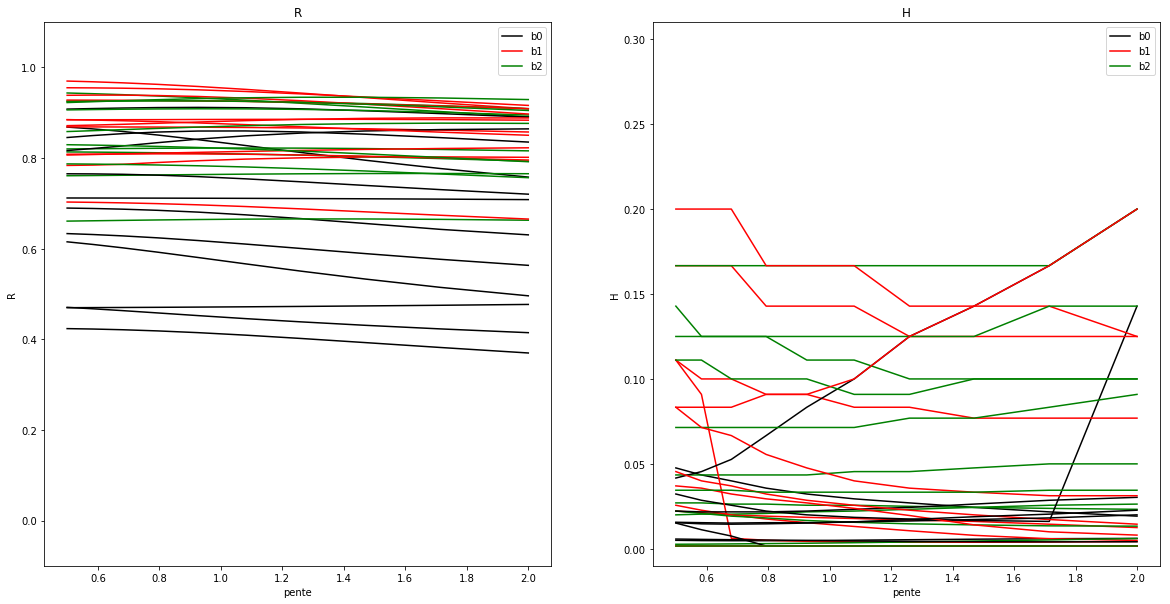

In [10]:
fig, ax = plt.subplots(1,2,figsize=(2*10,10))

list_k = np.logspace(-1, 1, 10, base=2)
print('sans logit|avec logit (max r)\n')
print('\t\tBlock 0\t\t\tBlock 1\t\t\tBlock 2')
print('-'*85)


for num, s in enumerate(h_k_s.keys()) :
    h_k, r_k = np.array(h_k_s[s]), np.array(r_k_s[s])
    
    r0, r1, r2 = np.max(r_k[:, 0]), np.max(r_k[:, 1]), np.max(r_k[:, 2])
    arg0, arg1, arg2 = np.argmax(r_k[:, 0]), np.argmax(r_k[:, 1]), np.argmax(r_k[:, 2])
    h0, h1, h2 = h_k[arg0, 0], h_k[arg1, 1], h_k[arg2, 2]
    
    if arg0==0 : k0 = 1
    else :       k0 = list_k[arg0-1]
        
    if arg1==0 : k1 = 1
    else :       k1 = list_k[arg1-1]
        
    if arg2==0 : k2 = 1
    else :       k2 = list_k[arg2-1]
    
    print('%s\tk:\t         |%.3f\t\t        |%.3f\t\t        |%.3f'%(s, k0, k1, k2))
    print('\th(tau):\t%.3f(%.0f)|%.3f(%.0f)\t%.3f(%.0f)|%.3f(%.0f)\t%.3f(%.0f)|%.3f(%.0f)'%(h_k[0,0], 1/h_k[0,0], h0, 1/h0,
                                                                                            h_k[0,1], 1/h_k[0,1], h1, 1/h1,
                                                                                            h_k[0,2], 1/h_k[0,2], h2, 1/h2))
    print('\tr:\t%.3f    |%.3f\t\t   %.3f|%.3f\t\t   %.3f|%.3f'%(r_k[0,0], r0, r_k[0,1], r1, r_k[0,2], r2))
    print('-'*85)

    for block, c in zip(range(3), ['k', 'r', 'g']) :
        ax[0].plot(list_k, r_k[1:,block], c=c, label='b%s'%block if num==0 else '')
        ax[1].plot(list_k, h_k[1:,block], c=c, label='b%s'%block if num==0 else '')

ax[0].set_ylim(-0.1, 1.1)
ax[1].set_ylim(-0.01, 0.31)
        
ax[0].set_title('R') ; ax[1].set_title('H')
ax[0].set_ylabel('R') ; ax[1].set_ylabel('H')
for a in range(2) : ax[a].legend() ; ax[a].set_xlabel('pente')

/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


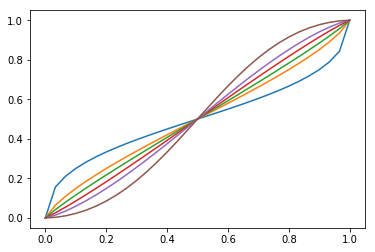

In [11]:
p = np.linspace(0, 1, 31)

for k in [0.500, 0.794, 0.926, 1.080, 1.260, 1.714]:
    plt.plot(p, sigmoid(k*logit(p)))

IP


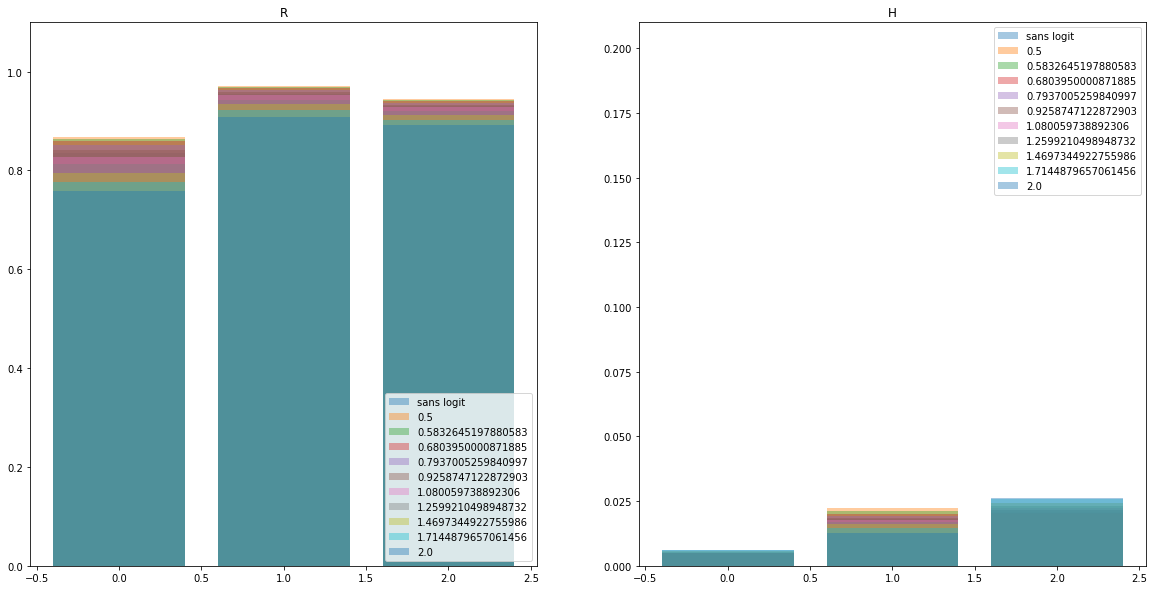

BMC


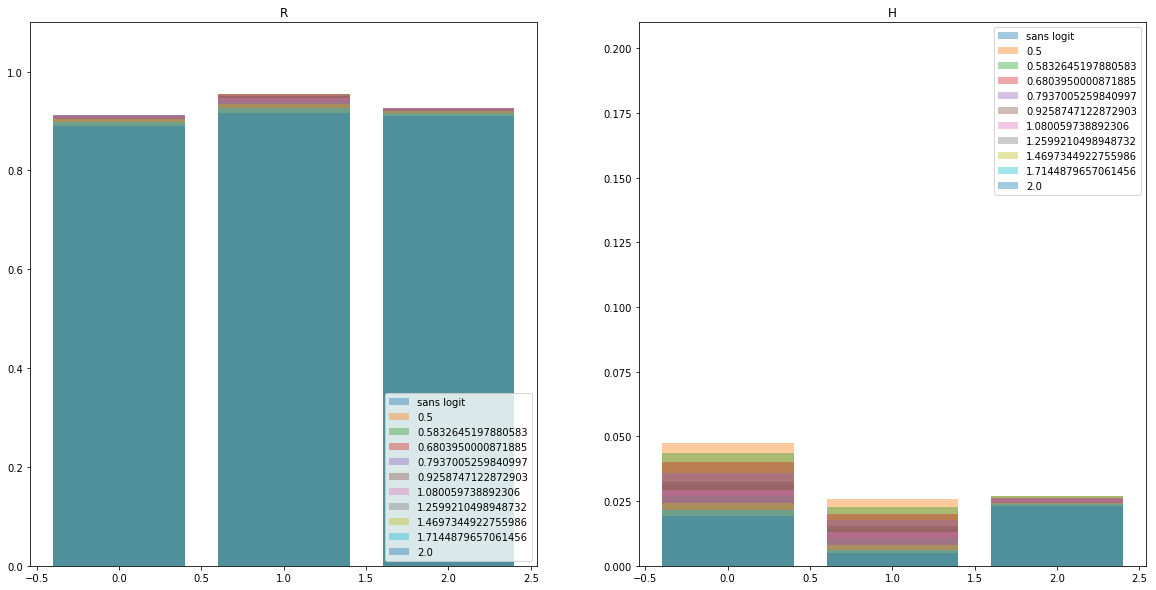

LB


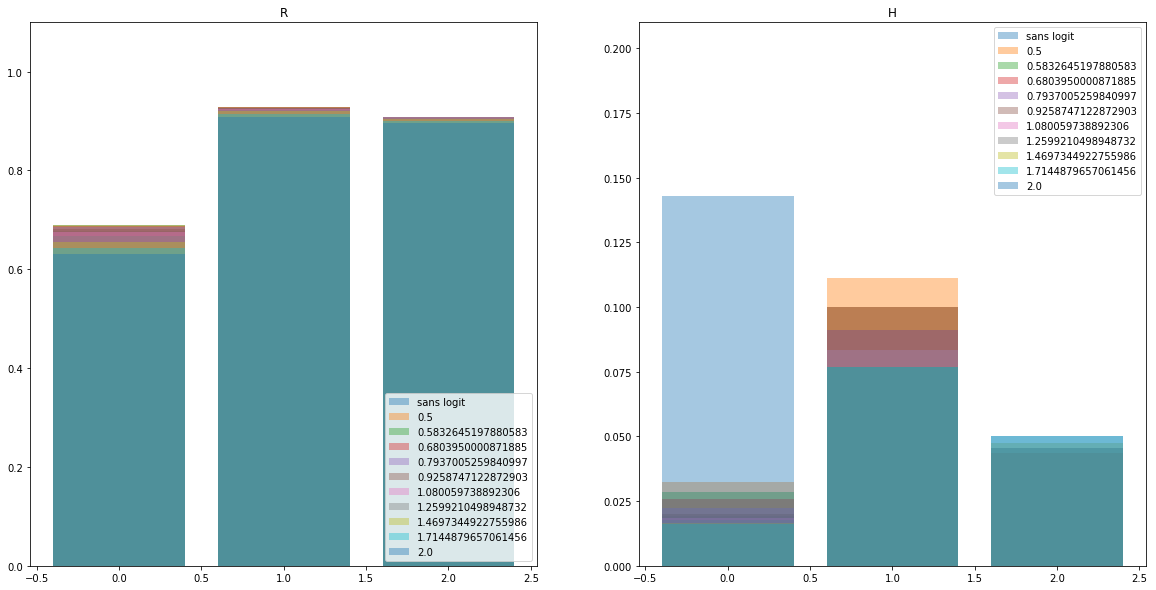

RS


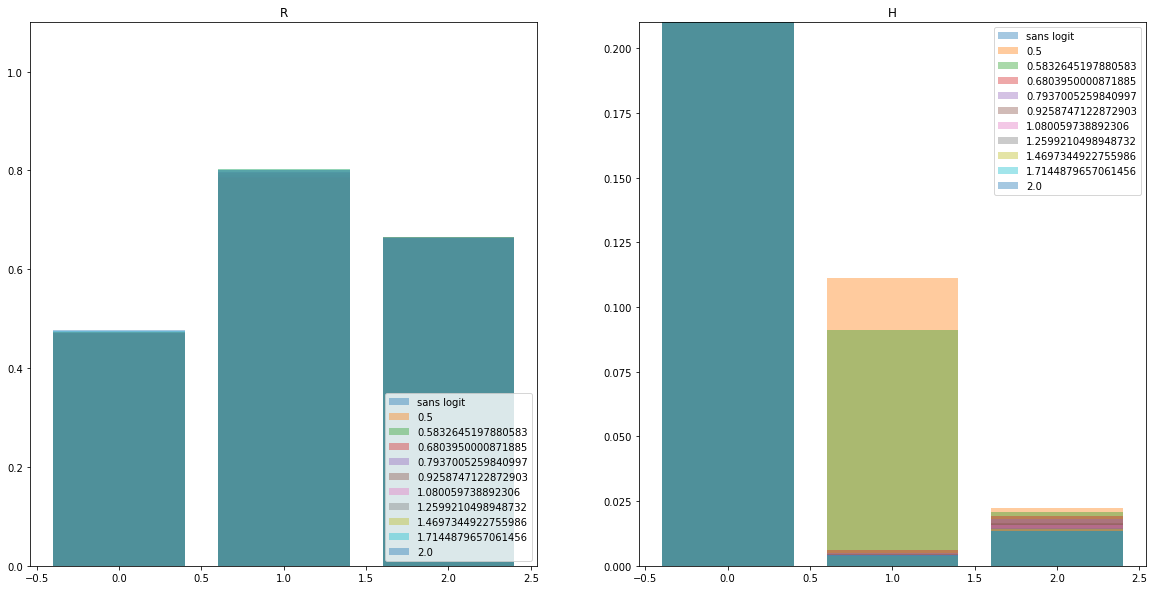

AM


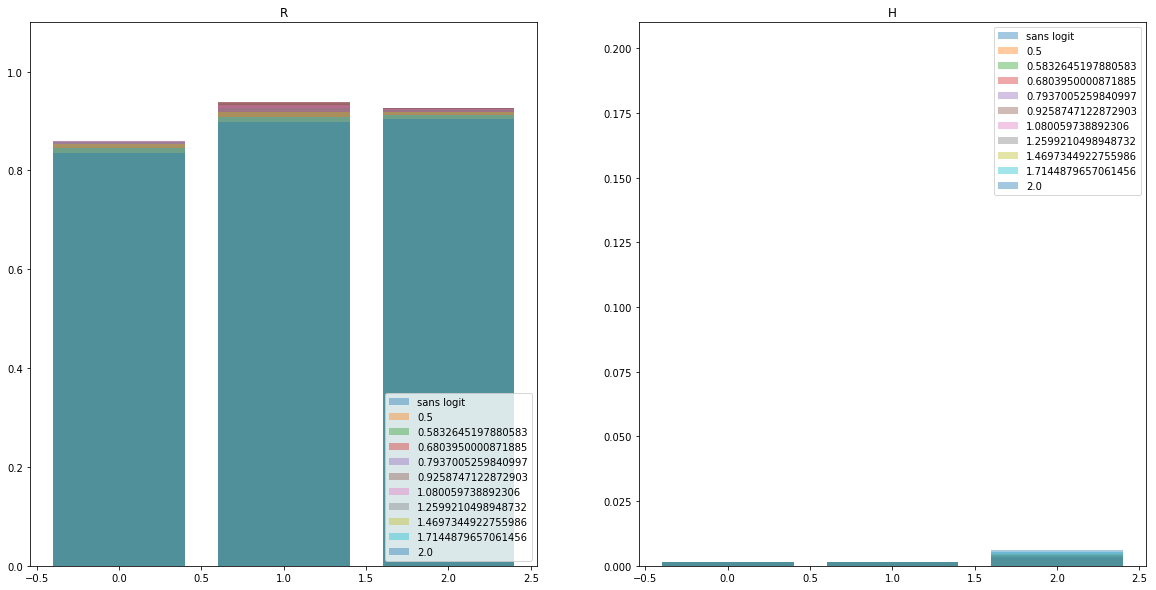

CS


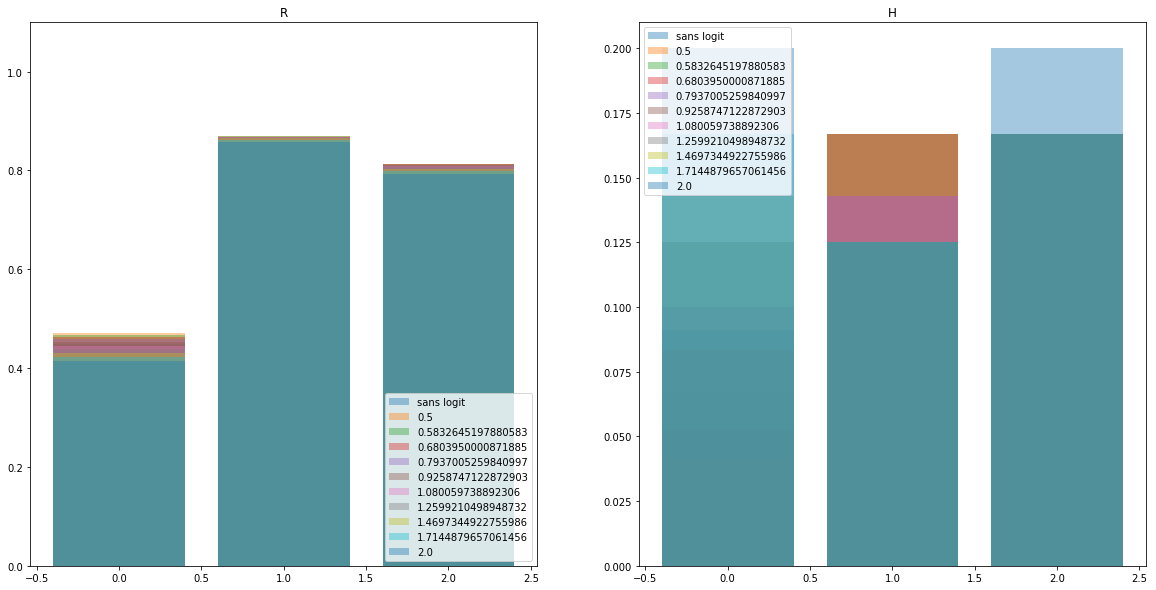

DC


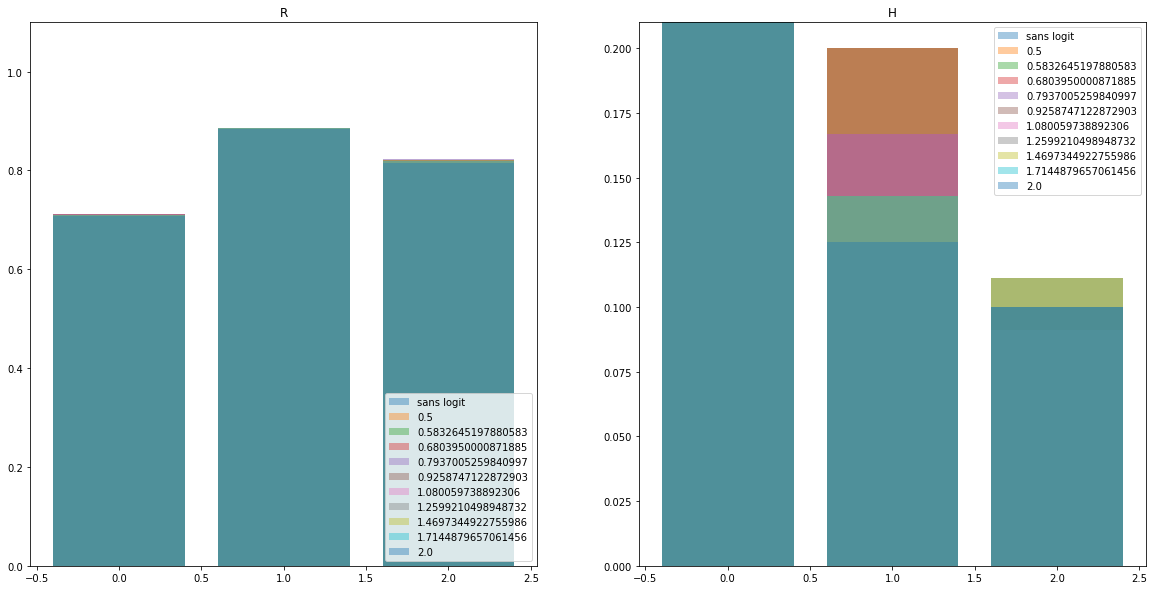

SR


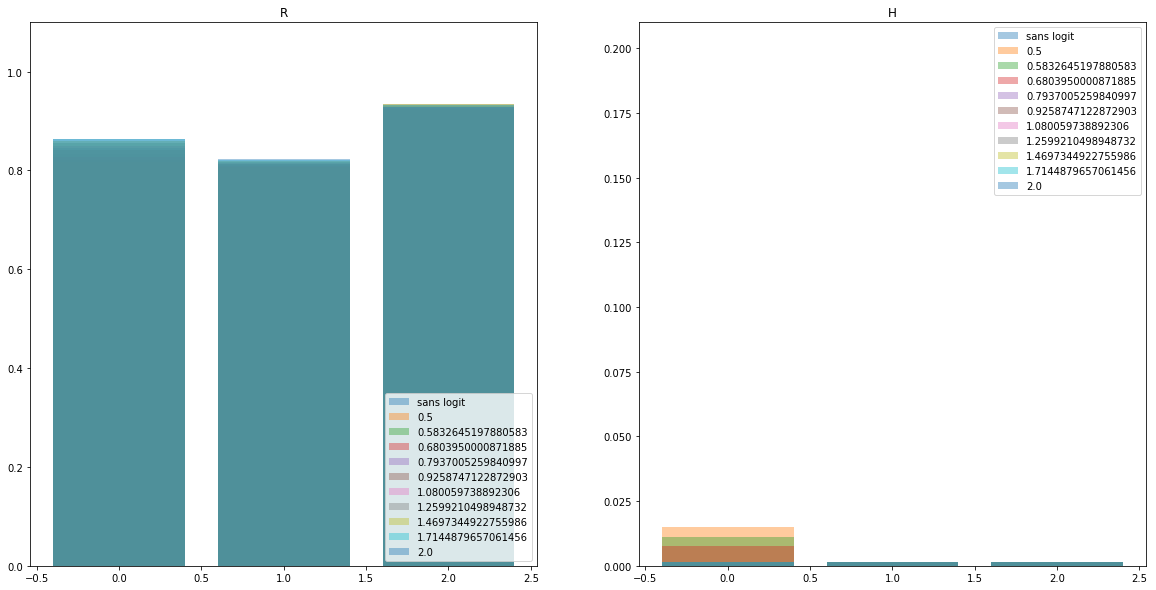

OP


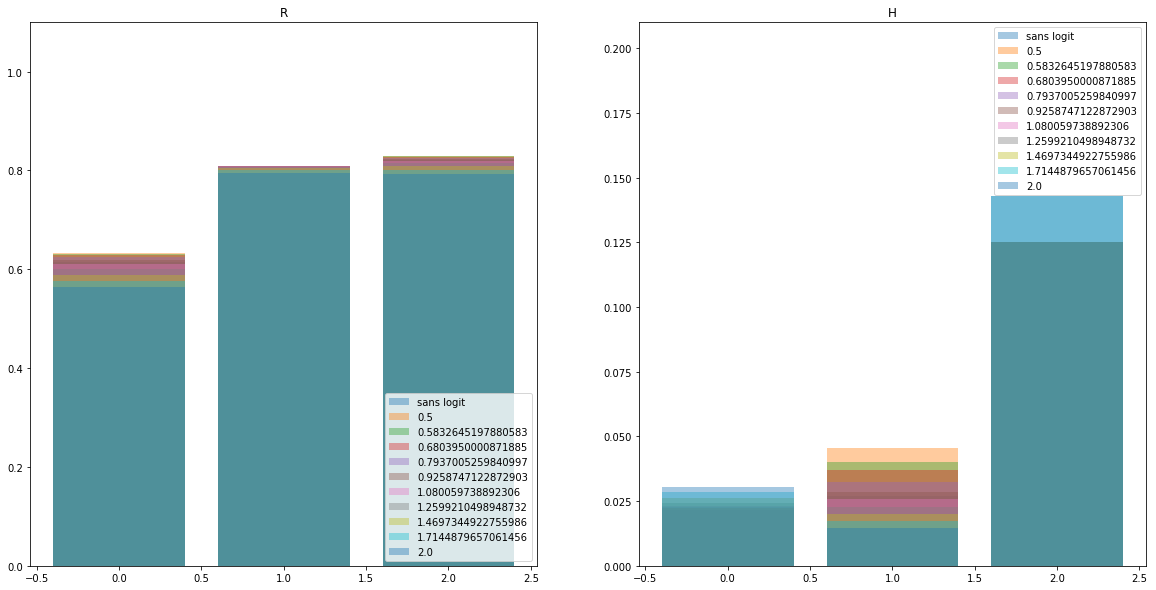

YK


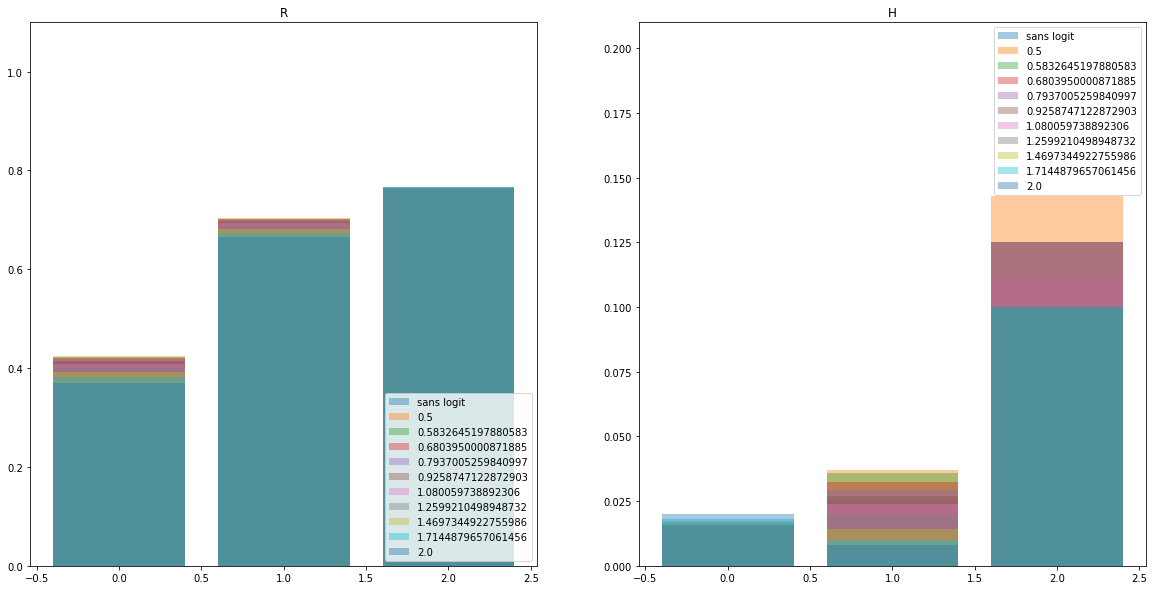

FM


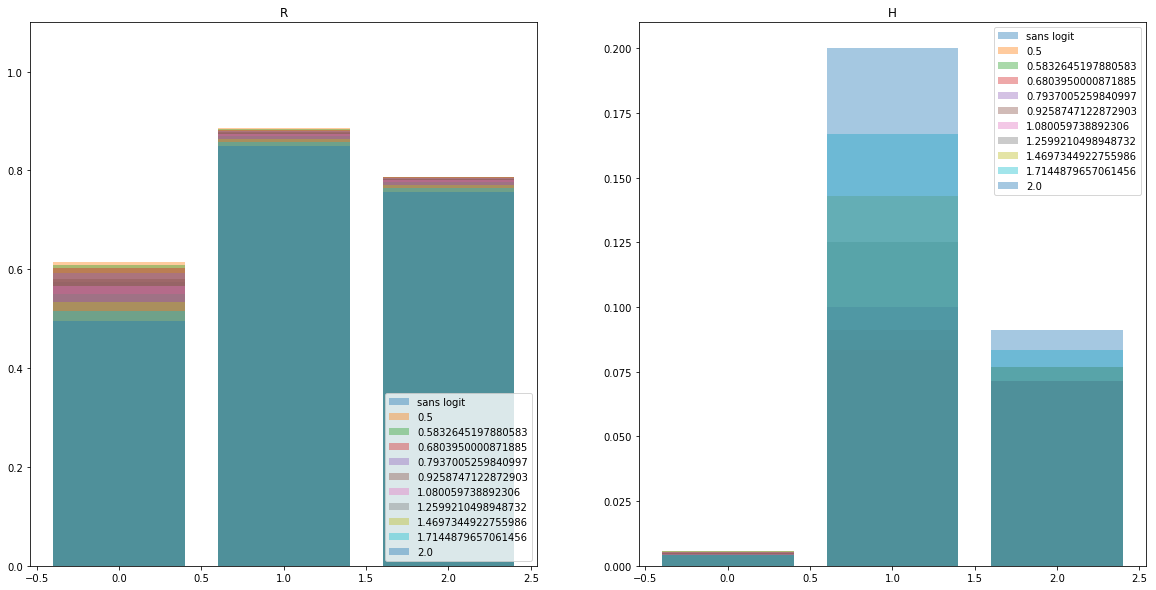

TN


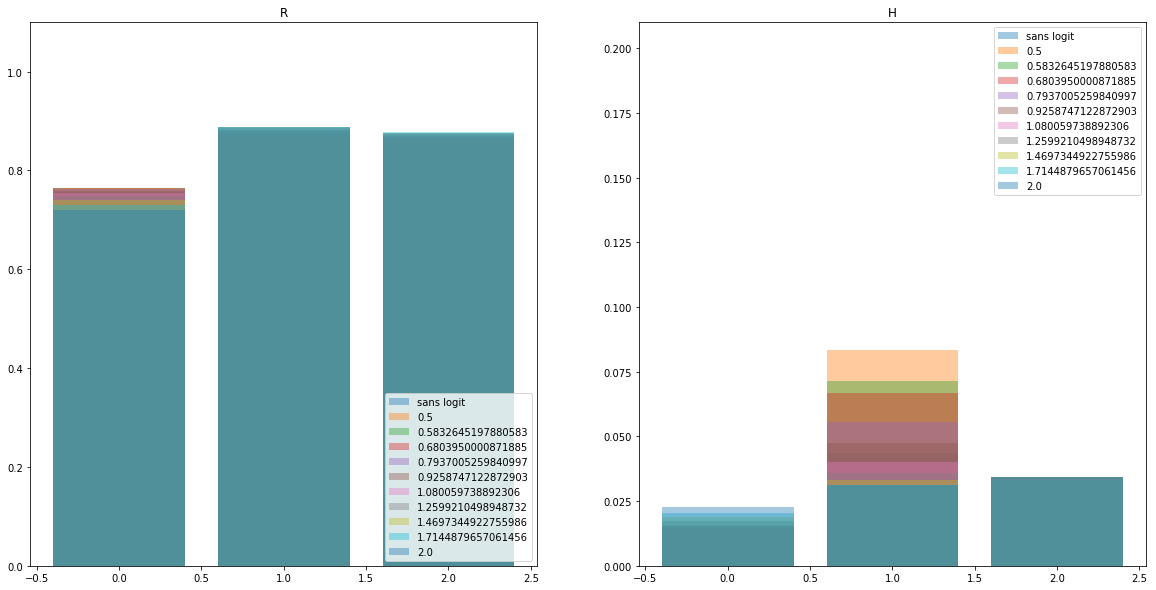

In [12]:
for num, s in enumerate(h_k_s.keys()) :
    h_k, r_k = h_k_s[s], r_k_s[s]
    print(s)
    
    fig, ax = plt.subplots(1,2,figsize=(2*10,10))

    ax[0].bar(np.arange(len(r_k[0])), r_k[0], alpha=0.4, label='sans logit')
    ax[1].bar(np.arange(len(h_k[0])), h_k[0], alpha=0.4, label='sans logit')

    for num, k in enumerate(np.logspace(-1, 1, 10, base=2)) :
        ax[0].bar(np.arange(len(r_k[num+1])), r_k[num+1], alpha=0.4, label=k)
        ax[1].bar(np.arange(len(h_k[num+1])), h_k[num+1], alpha=0.4, label=k)

    ax[0].legend(loc=4) ; ax[1].legend()
    ax[0].set_ylim(0, 1.1)
    #ax[1].set_ylim(min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
    ax[1].set_ylim(0, 0.21)
    ax[0].set_title('R') ; ax[1].set_title('H')
    plt.show()